In [2]:
%load_ext autoreload
%autoreload 2
from load import *
import torch
import yaml
import logging
from imp import reload
import matplotlib.pyplot as plt
from liftpose.vision_3d import world_to_camera_dict, reprojection_error
reload(logging)
logger = logging.getLogger(__name__).setLevel(logging.INFO)
from tqdm import tqdm
tqdm.get_lock().locks = []
plt.style.use('dark_background')
# decleare data parameters
# decleare data parameters
par_train = {  'data_dir'       : '/data/LiftPose3D/fly_tether/data_DF3D/', # change the path 
           'out_dir'        : '/data/LiftPose3D/fly_tether/cams_test/',
           'train_subjects' : [1],
           'test_subjects'  : [1],
           'actions'        : ['all'],
           'cam_id'         : [0,6]}

# merge with training parameters
par_data = yaml.full_load(open('param.yaml', "rb"))
par = {**par_data["data"], **par_train}

In [8]:
# reproduce from code-ocean
def abs_error(abs_error,n_pts):
    error = np.zeros((abs_error.shape[0], n_pts))
    for k in range(n_pts):
        error[:, k] = np.mean(abs_error[:, 3*k:3*(k + 1)], axis=1)
        
    return error

import stats
lift = torch.load('test_results.pth.tar')
stat = torch.load('stat_3d.pth.tar')

#lifting error
dimensions = stat['targets_3d']
lift_tar = stats.unNormalize(lift['target'], stat['mean'][dimensions], stat['std'][dimensions])
lift_out = stats.unNormalize(lift['output'], stat['mean'][dimensions], stat['std'][dimensions])

absdiff = np.abs(lift_tar - lift_out)
n_pts = len(dimensions)//3
lift_error = abs_error(absdiff,n_pts)

In [10]:
lift_tar = lift_tar.reshape(105305, 12, 3)
lift_out = lift_out.reshape(105305, 12, 3)

In [64]:
lift_tar.shape

(105305, 12, 3)

In [56]:
ckpt = torch.load('ckpt_best.pth.tar')

In [60]:
ckpt['lr']

0.00096

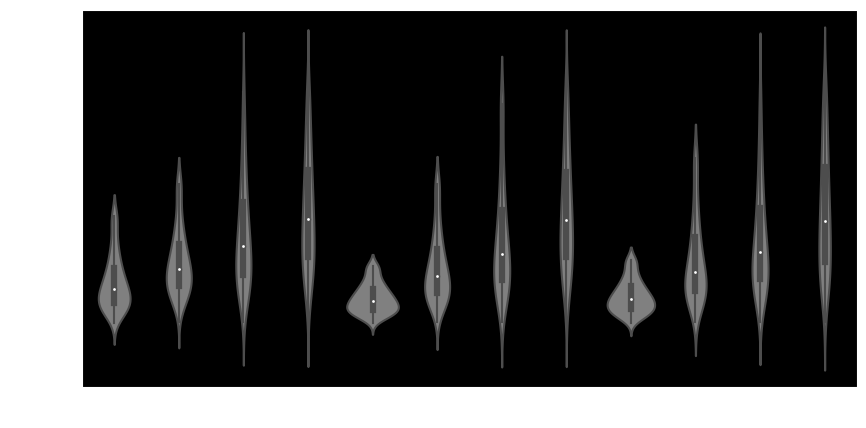

In [11]:
# check violin plot 
# does it coincide with the mean values?
%matplotlib inline
from liftpose.plot import violin_plot
import random, string
#order = ['HeadF', 'HeadB', 'HeadL', 'SpineM', 'SpineL', 'HipL', 'HipR', 'ElbowL', 'ArmL', 'ShoulderL', 'ShoulderR', 'ElbowR', 'ArmR', 'KneeR', 'KneeL', 'ShinL', 'ShinR']
plt.figure(figsize=(10,5), dpi=100)
names = [str(i) for i in range(12)]
#order = names.copy()
#order.remove('Neck')
#order.remove('Tail')
ax = plt.gca()
violin_plot(ax, test_3d_gt=lift_tar, test_3d_pred=lift_out, test_keypoints=np.ones_like(lift_out),
                joints_name=names, order=names)

In [3]:
from liftpose.postprocess import load_test_results
from liftpose.main import test as lp3d_test


lp3d_test(par['out_dir'])
data = torch.load(os.path.join(par['out_dir'], "test_results.pth.tar"))
stat_2d, stat_3d = (
    torch.load(os.path.join(par['out_dir'], "stat_2d.pth.tar")),
    torch.load(os.path.join(par['out_dir'], "stat_3d.pth.tar")),
)
test_3d_gt, test_3d_pred, good_keypts = load_test_results(data, stat_2d, stat_3d)

[main.py:409]:INFO:starting testing in path: /data/LiftPose3D/fly_tether/cams_test/
[lift.py:31]:INFO:Training on the device: cuda:0
[lift.py:57]:INFO:total params: 4.27M
[lift.py:63]:INFO:loading ckpt from '/data/LiftPose3D/fly_tether/cams_test/ckpt_best.pth.tar'
[lift.py:71]:INFO:ckpt loaded (epoch: 97 | err: 0.28578473542058247)
[lift.py:107]:INFO:Saving results: /data/LiftPose3D/fly_tether/cams_test/test_results.pth.tar


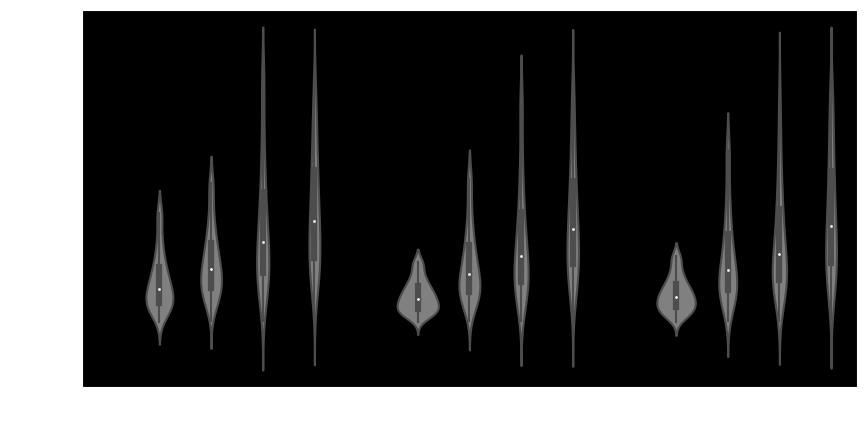

In [6]:
# check violin plot 
# does it coincide with the mean values?
%matplotlib inline
from liftpose.plot import violin_plot
import random, string
#order = ['HeadF', 'HeadB', 'HeadL', 'SpineM', 'SpineL', 'HipL', 'HipR', 'ElbowL', 'ArmL', 'ShoulderL', 'ShoulderR', 'ElbowR', 'ArmR', 'KneeR', 'KneeL', 'ShinL', 'ShinR']
plt.figure(figsize=(10,5), dpi=100)
names = [str(i) for i in range(15)]
#order = names.copy()
#order.remove('Neck')
#order.remove('Tail')
ax = plt.gca()
violin_plot(ax, test_3d_gt=test_3d_gt, test_3d_pred=test_3d_pred, 
                test_keypoints=good_keypts,
                joints_name=names, order=names)
#plt.ylim([0,15])

In [18]:
import pandas as pd
def abs_error(abs_error,n_pts):
    error = np.zeros((abs_error.shape[0], n_pts))
    for k in range(n_pts):
        error[:, k] = np.mean(abs_error[:, 3*k:3*(k + 1)], axis=1)
        
    return error

#load
tri = pickle.load(open('/data/LiftPose3D/fly_tether/lift_vs_tri/retriangulation.pkl','rb'))
stat = torch.load('/data/LiftPose3D/fly_tether/cams_test/stat_3d.pth.tar')
dimensions = stat['targets_3d']
n_pts = len(dimensions)//3

#triangulation error
#triangulation error
tri_3cam  = tri[(0, 1, 2, 4, 5, 6)]
tri_2cam = tri[(0, 1, 4, 6)]
absdiff = np.abs(tri_3cam - tri_2cam)
absdiff = np.reshape(absdiff, (absdiff.shape[0], absdiff.shape[1]*absdiff.shape[2]))
absdiff = absdiff[:,dimensions]
tri_error = abs_error(absdiff,n_pts)

nframes = tri_error.shape[0]

#add overall error
tri_error = np.hstack((tri_error,np.mean(tri_error,axis=1)[:,None]))

#make pandas dataframe
tri_error=tri_error.flatten()
error = np.concatenate((tri_error,tri_error))
error = pd.DataFrame({'joint': ['coxa-femur', 'femur-tibia', 'tibia-tarsus', 'tarsus-tip', 'overall'] * nframes * 2,
                   'method': ['tri' for i in range(len(tri_error))] + ['lift' for i in range(len(tri_error))],
                   'error': error})

ValueError: arrays must all be same length

In [21]:
tri_error[:100]

array([0.03846803, 0.0515615 , 0.04025309, 0.09420177, 0.06355817,
       0.01923272, 0.03524268, 0.03844251, 0.04154748, 0.01642994,
       0.04730865, 0.04359207, 0.01417143, 0.02912976, 0.03277989,
       0.05649539, 0.01389538, 0.01517855, 0.03584469, 0.04910129,
       0.00824848, 0.03069177, 0.02150102, 0.04390961, 0.03669941,
       0.03846803, 0.0515615 , 0.04025309, 0.0874911 , 0.06355817,
       0.03702676, 0.03524268, 0.03308012, 0.04154748, 0.01642994,
       0.02416645, 0.0452568 , 0.01417143, 0.03135443, 0.03575711,
       0.05649539, 0.01803094, 0.01517855, 0.03584469, 0.04910129,
       0.00824848, 0.03069177, 0.02150102, 0.04696254, 0.03655916,
       0.01064296, 0.0515615 , 0.04025309, 0.0874911 , 0.06355817,
       0.01923272, 0.03524268, 0.03844251, 0.04154748, 0.02210892,
       0.02416645, 0.04695654, 0.01417143, 0.02912976, 0.03277989,
       0.05649539, 0.01389538, 0.01517855, 0.03584469, 0.04607589,
       0.00824848, 0.0218313 , 0.02150102, 0.04696254, 0.03430

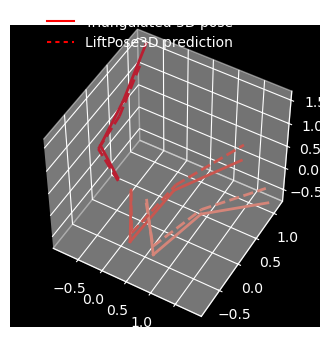

In [12]:
# https://stackoverflow.com/a/38865534/7554774
# conda install ipympl
#%matplotlib widget
%matplotlib inline
from liftpose.plot import plot_pose_3d

fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=50, azim=-60)

t = 30000
plot_pose_3d(ax=ax, tar=test_3d_gt[t], 
            pred=test_3d_pred[t], 
            bones=par_data["vis"]["bones"], 
            limb_id=par_data["vis"]["limb_id"], 
            colors=par_data["vis"]["colors"],
            good_keypts=good_keypts[t])